todo:

- correlations
- Cross validations 
- Redandency

## Data Understanding

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statistics
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [3]:
set1_df = pd.read_csv(r'../data/set9_it1.csv')
set2_df = pd.read_csv(r'../data/set9_it2.csv')
set3_df = pd.read_csv(r'../data/set9_it3.csv')

In [4]:
print(set1_df.isna().sum())
print(set2_df.isna().sum())
print(set3_df.isna().sum())


DI                  0
TradeValue          0
RealmType           0
Enclave             0
LivingQuarters    117
ParcelSize          0
ParcelSizeUnit      0
dtype: int64
DI                     0
StructuralIntegrity    0
ExteriorCharm          0
dtype: int64
DI                0
Craftsmanship     0
EraConstructed    0
dtype: int64


### Checking new data before cleaning

In [5]:
## if anyone has any idea what to check do it here 

## Data Preperation

In [6]:
# deleteing the rows with missing values 
set1_df.dropna(inplace=True)
# removes the duplicate rows in place
set1_df.drop_duplicates(inplace=True)
set2_df.drop_duplicates(inplace=True)
set3_df.drop_duplicates(inplace=True)

# Removing parcelSize below one
set1_df.drop(set1_df[set1_df['ParcelSize'] < 1].index, inplace=True)

# Cleaning capitalisation 
set1_df['Enclave'] = set1_df['Enclave'].str.capitalize()

# Replacing typos after manual inspection
set1_df['Enclave'] = set1_df['Enclave'].replace('Sunspires', 'Sunspire')
set1_df['Enclave'] = set1_df['Enclave'].replace('Dragonspires', 'dragonspire')

# Converting incosintent metrics
SQFT_TO_SQM = 0.092903

set1_df.loc[set1_df["ParcelSizeUnit"] == "sqft", "ParcelSize"] *= SQFT_TO_SQM
set1_df.loc[set1_df["ParcelSizeUnit"] == "sqft", "ParcelSizeUnit"] = "sqm"


In [7]:
df = set1_df.merge(set2_df, left_on='DI', right_on='DI')
df = df.merge(set3_df, left_on='DI', right_on='DI')

In [8]:

# Transforming ExteriorCharm to a Ordinal level of messeruments 
sortedCharms = list(df.groupby('ExteriorCharm')['TradeValue'].mean().sort_values().index)

df['ExteriorCharm'] = df['ExteriorCharm'].map(lambda x: sortedCharms.index(x))
df['RealmType'].unique()

array(['Meadowlands', 'GnomeBurough', 'ArcaneMarket', 'AetherIsles',
       'CitadelQuarter'], dtype=object)

I would love to translate this into some kind of coefficent

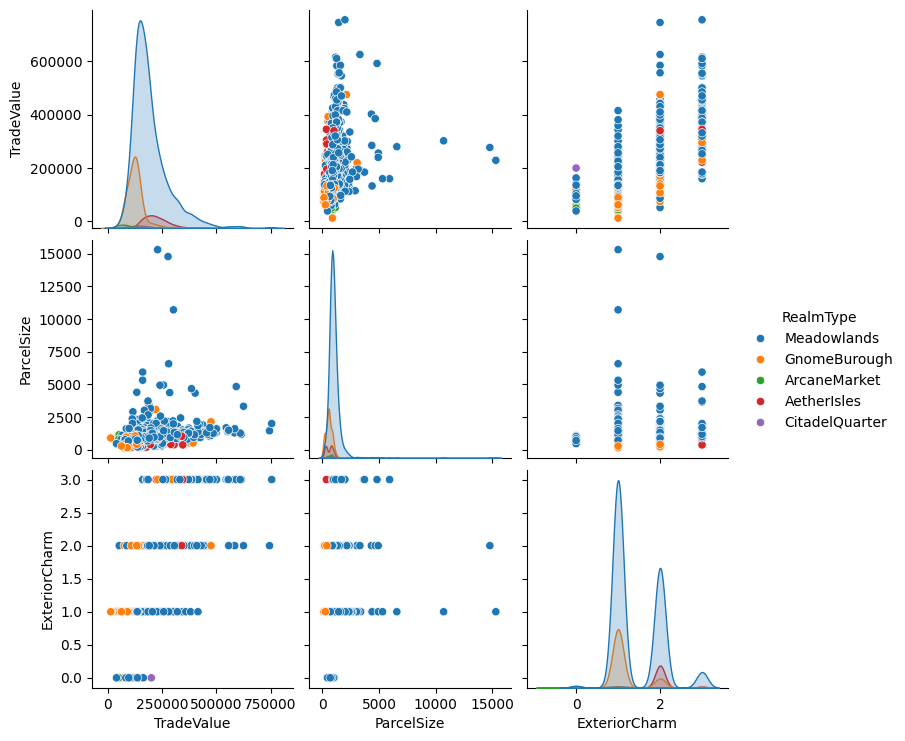

In [9]:
sns.pairplot(df[['TradeValue','RealmType','ParcelSize','ExteriorCharm']],hue='RealmType')

#### Try both alrogithms 

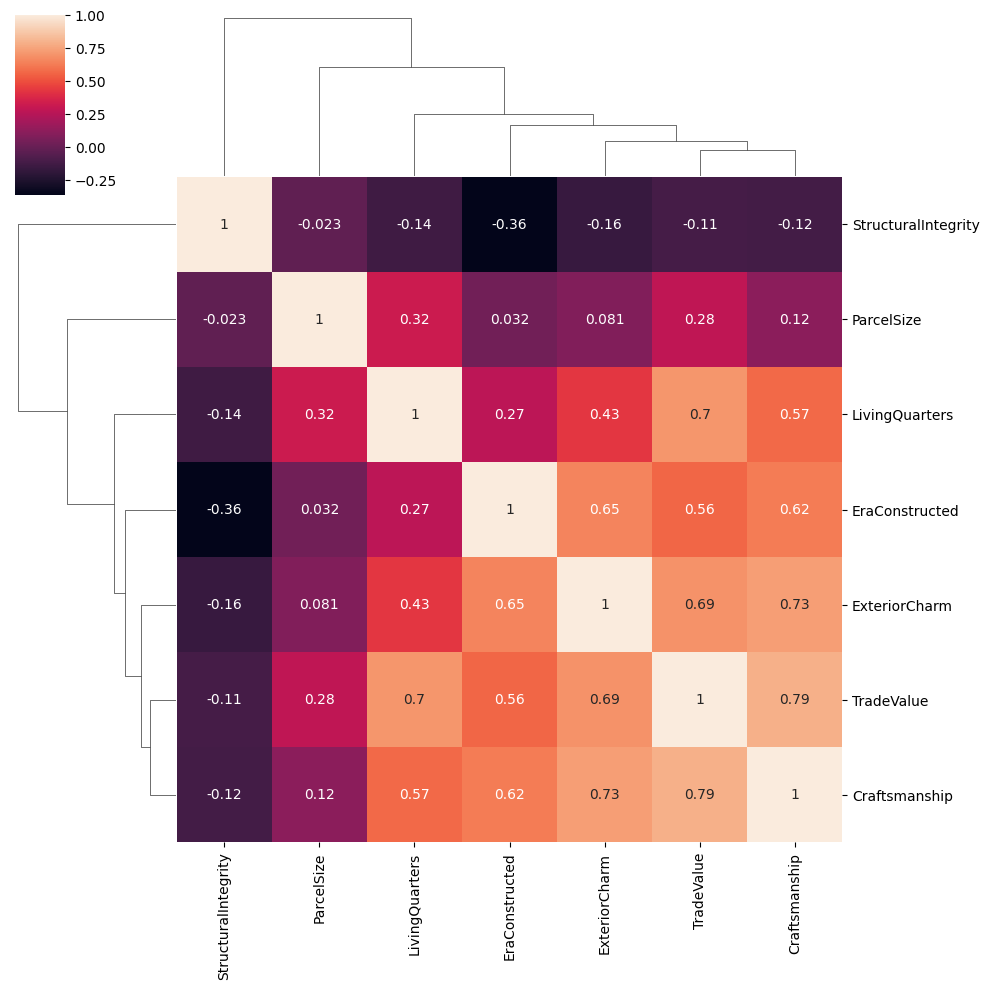

In [19]:
sns.clustermap(
	df.filter(items=[col for col in df.columns if col not in ['RealmType','Enclave','ParcelSizeUnit','DI','NeedsRestoration']]).corr(),
	annot=True
	)
	

## Modeling

## Classfication modeling

Index(['TradeValue', 'LivingQuarters', 'ExteriorCharm', 'Craftsmanship'], dtype='object')


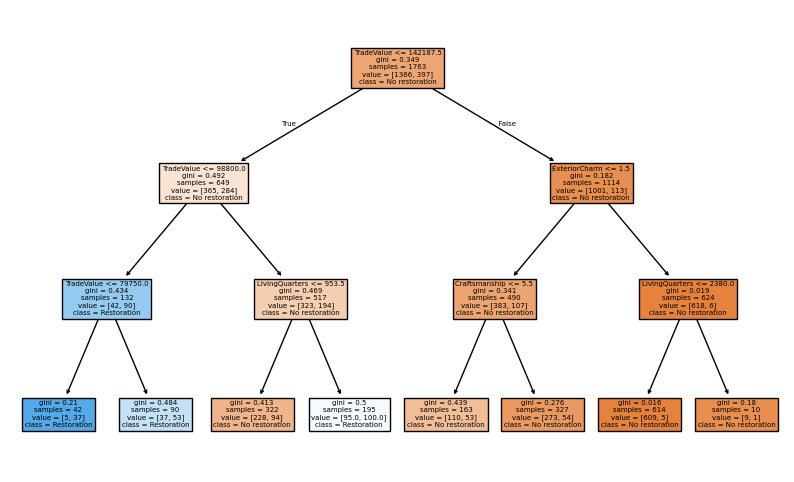

In [11]:
# for classifcation
def calculate_needs_restoration(row):
    age_factor = 1 if row['EraConstructed'] < 1300 else 0 
    structure_factor = 1 if row['StructuralIntegrity'] <= 6 else 0
    total_factors = age_factor + structure_factor
    return True if total_factors >= 2 else False

df["NeedsRestoration"] = df.apply(calculate_needs_restoration, axis=1)

features = df.filter(items=[col for col in df.columns if col not in ["ParcelSize","EraConstructed","StructuralIntegrity","RealmType","Enclave","ParcelSizeUnit","NeedsRestoration","DI"]])
print(features.columns)

X_train, X_test,y_train, y_test = train_test_split(features,df['NeedsRestoration'], test_size=0.2, random_state=42)


clf = DecisionTreeClassifier(max_depth=3,
                             min_samples_leaf=10
							 )
clf.fit(X_train,y_train)

plt.figure(figsize=(10,6))
plot_tree(clf, feature_names=features.columns, class_names=['No restoration', 'Restoration'], filled=True)
plt.show()
y_pred = clf.predict(X_test)








## Evaluation with cross validation

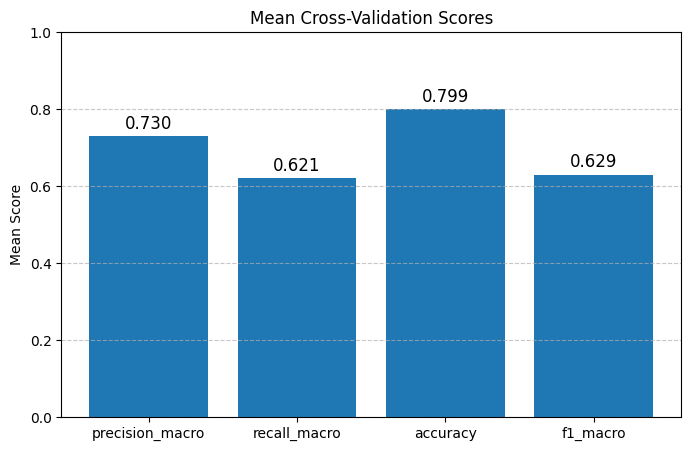

In [23]:
from sklearn.model_selection import cross_validate

scoring = ['precision_macro', 'recall_macro','accuracy','f1_macro']
scores = cross_validate(clf, features, df['NeedsRestoration'], scoring=scoring)

mean_scores = {key: np.mean(value) for key, value in scores.items() if key.startswith('test_')}
mean_scores = {key.replace("test_", ""): value for key, value in mean_scores.items()}

# Visualization
plt.figure(figsize=(8, 5))
plt.bar(mean_scores.keys(), mean_scores.values())
plt.ylim(0, 1)
plt.ylabel("Mean Score")
plt.title("Mean Cross-Validation Scores")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show values on bars
for i, (metric, score) in enumerate(mean_scores.items()):
    plt.text(i, score + 0.02, f"{score:.3f}", ha='center', fontsize=12)

plt.show()

# Evaluation on single test split

In [ ]:

# Predicted values from test_set
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
total = len(y_test)

# Compute metrics
error_rate = (FP + FN) / total
accuracy = (TP + TN) / total
true_positive_rate = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
true_negative_rate = TN / (TN + FP) if (TN + FP) > 0 else 0
positive_predictive_value = TP / (TP + FP) if (TP + FP) > 0 else 0

# Print results
print(f"Confusion Matrix:\n{cm}")
print(f"Total Instances: {total}")
print(f"False Negatives: {FN}")
print(f"False Possitives: {FP}")
print(f"Error Rate (Misclassification Rate): {error_rate:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"True Positive Rate (TPR / Recall): {true_positive_rate:.4f}")
print(f"True Negative Rate (TNR / Specificity): {true_negative_rate:.4f}")
print(f"Positive Predictive Value (PPV / Precision): {positive_predictive_value:.4f}")


Confusion Matrix:
[[325  29]
 [ 47  40]]
Total Instances: 441
False Negatives: 47
False Possitives: 29
Error Rate (Misclassification Rate): 0.1723
Accuracy: 0.8277
True Positive Rate (TPR / Recall): 0.4598
True Negative Rate (TNR / Specificity): 0.9181
Positive Predictive Value (PPV / Precision): 0.5797
